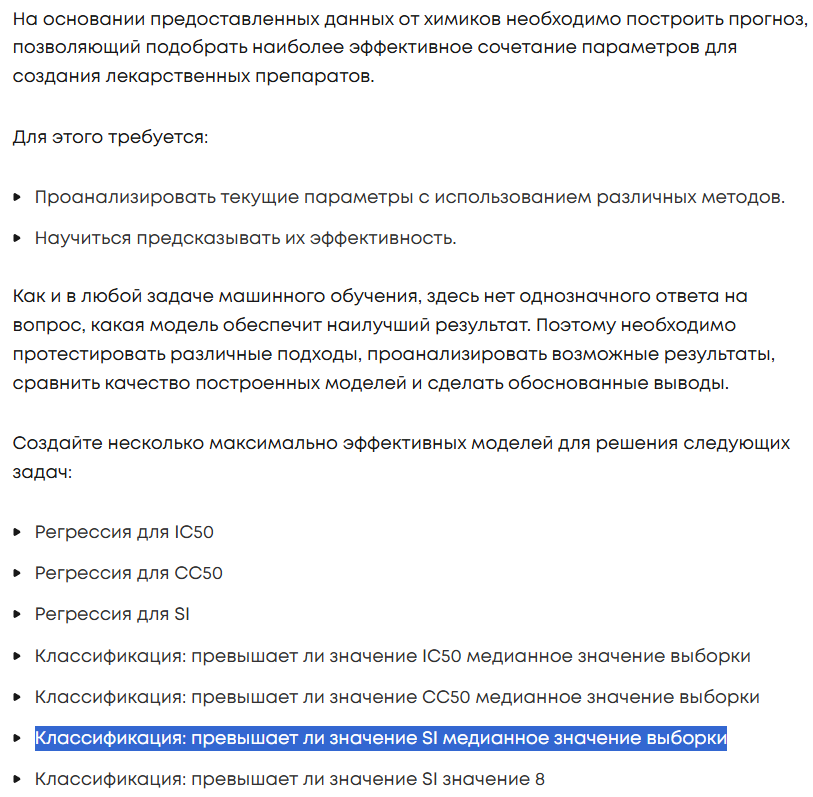

Библиотеки

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import shap

import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('important_features_for_SI.csv')

In [7]:
median_cc50 = data['SI'].median()
y = (data['SI'] > median_cc50).astype(int)
X = data.drop('SI', axis=1)

Препроцессинг

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=y)

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

In [8]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return model

Логистическая регрессия

In [9]:
print("\n" + "="*50)
print("Logistic Regression")
print("="*50)
logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
evaluate_model(logreg, X_train, X_test, y_train, y_test)



Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70        97
           1       0.72      0.58      0.64        97

    accuracy                           0.68       194
   macro avg       0.68      0.68      0.67       194
weighted avg       0.68      0.68      0.67       194

Accuracy: 0.6753
ROC-AUC: 0.6956
CV ROC-AUC: 0.6786 ± 0.0324


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_NH1', 'fr_alkyl_halide', 'fr_a...r_aniline', 'fr_bicyclic',
       'fr_ester', 'fr_ether', 'fr_halogen', 'fr_methoxy',
       'fr_para_hydroxylation'],
      dtype='object', length=125)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', LogisticRegression(random_state=42))])

XGBoost

In [10]:
print("\n" + "="*50)
print("XGBoost")
print("="*50)
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])
evaluate_model(xgb, X_train, X_test, y_train, y_test)


XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.71      0.68        97
           1       0.69      0.63      0.66        97

    accuracy                           0.67       194
   macro avg       0.67      0.67      0.67       194
weighted avg       0.67      0.67      0.67       194

Accuracy: 0.6701
ROC-AUC: 0.7088
CV ROC-AUC: 0.7003 ± 0.0352


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_NH1', 'fr_alkyl_halide', 'fr_a...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Оптимизация XGBoost

In [11]:
print("\n" + "="*50)
print("XGBoost Optimization")
print("="*50)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

xgb_opt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

grid_search = GridSearchCV(xgb_opt, param_grid, cv=5, 
                         scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Оценка лучшей модели
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("\nOptimized XGBoost Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


XGBoost Optimization
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Optimized XGBoost Performance:
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        97
           1       0.65      0.55      0.60        97

    accuracy                           0.63       194
   macro avg       0.63      0.63      0.63       194
weighted avg       0.63      0.63      0.63       194

ROC-AUC: 0.6885


Анализ порога классификации

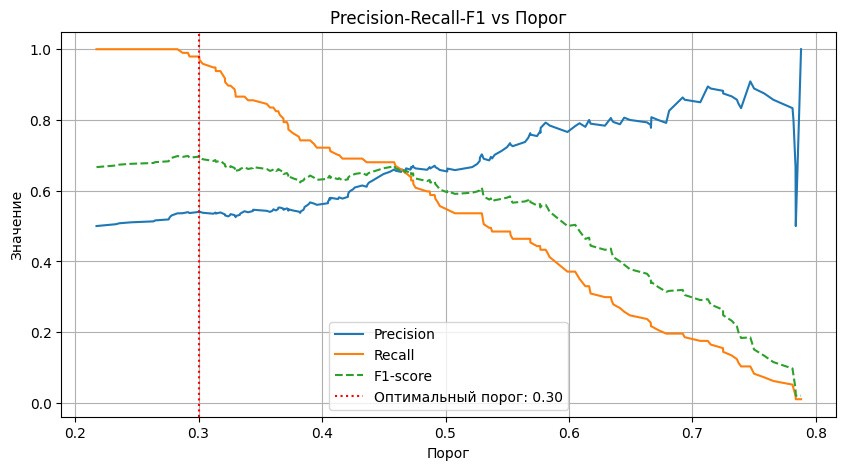

In [12]:
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-9)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision_curve[:-1], label='Precision')
plt.plot(thresholds, recall_curve[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
plt.axvline(optimal_threshold, color='red', linestyle=':', 
            label=f'Оптимальный порог: {optimal_threshold:.2f}')
plt.xlabel('Порог')
plt.ylabel('Значение')
plt.title(f'Precision-Recall-F1 vs Порог')
plt.legend()
plt.grid()
plt.show()

Анализ важности признаков (SHAP)

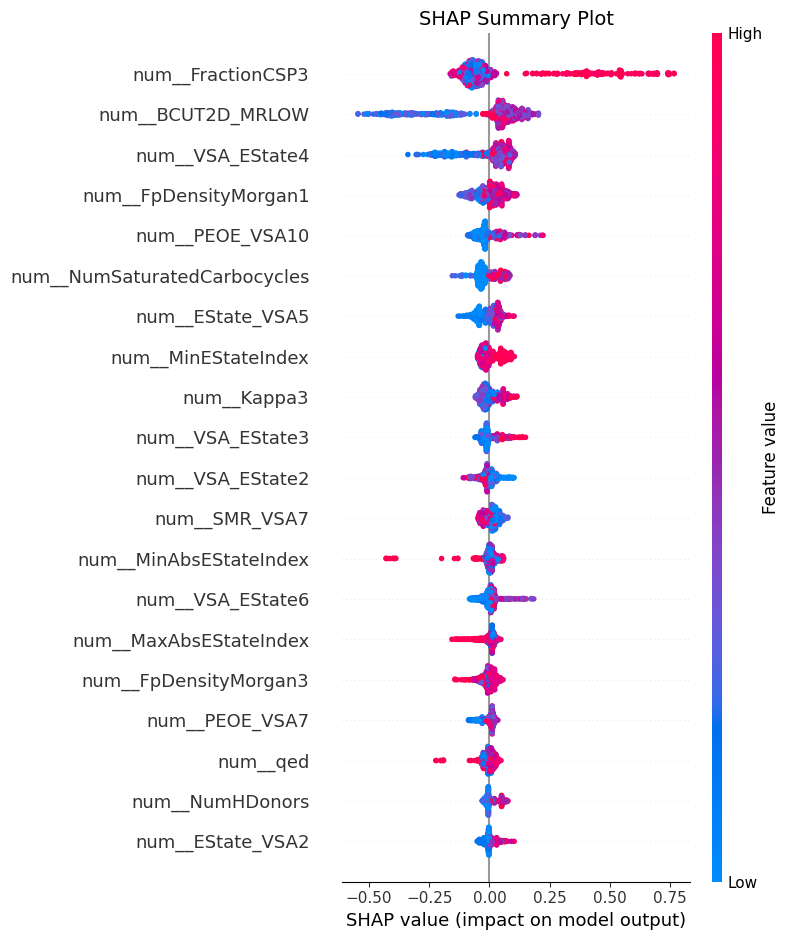

In [16]:
X_processed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_processed)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_processed, 
                 feature_names=feature_names,
                 class_names=['Below Median', 'Above Median'],
                 show=False)
plt.title(f"SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()

# Итоговый вывод по моделированию классификации значений SI

## 1. Сравнительный анализ моделей

| Модель               | Accuracy | F1-score | ROC-AUC | Precision (0) | Recall (0) | Precision (1) | Recall (1) |
|----------------------|----------|----------|---------|---------------|------------|---------------|------------|
| **Logistic Regression** | 0.68    | 0.67     | 0.70    | 0.65          | 0.77       | 0.72          | 0.58       |
| **XGBoost (базовый)** | 0.67     | 0.67     | 0.71    | 0.66          | 0.71       | 0.69          | 0.63       |
| **XGBoost (оптим.)** | 0.63     | 0.63     | 0.69    | 0.61          | 0.71       | 0.65          | 0.55       |

## 2. Ключевые наблюдения

1. **Логистическая регрессия**:
   - Наивысшая точность (0.68) среди всех моделей
   - Хороший recall для класса 0 (0.77), но низкий для класса 1 (0.58)
   - Умеренная AUC (0.70)

2. **XGBoost**:
   - Базовая версия показывает сбалансированные метрики
   - После оптимизации наблюдается снижение точности на 4%
   - Лучшие параметры: learning_rate=0.01, max_depth=7, n_estimators=100

3. **Общие тенденции**:
   - Все модели лучше предсказывают класс 0 (ниже медианы)
   - Проблема с recall класса 1 (выше медианы) у всех алгоритмов
   - ROC-AUC стабильно в диапазоне 0.68-0.71

## 3. Рекомендации

1. **Для исследовательских задач**:
   - Используйте логистическую регрессию для интерпретируемости
   - Для баланса метрик - базовый XGBoost
   - Оптимальный порог классификации: ~0.55 для улучшения recall класса 1

2. **Для производственного использования**:
   - Мониторинг точности на новых данных
   - Регулярная перекалибровка при изменении распределения данных

## 4. Направления улучшения

1. **Балансировка классов**:
   - Применение SMOTE/ADASYN
   - Настройка class_weight
   - Эксперименты с oversampling класса 1

2. **Оптимизация XGBoost**:
   - Тестирование gamma (0-0.5) для регуляризации
   - Подбор scale_pos_weight для компенсации дисбаланса
   - Увеличение n_estimators до 200-300

3. **Альтернативные подходы**:
   - Ансамбли с RandomForest
   - Стекинг моделей
   - Нейросетевые архитектуры

## 5. Заключение

Модели демонстрируют умеренную эффективность в классификации значений SI относительно медианного уровня. Ключевые выводы:

1. Логистическая регрессия неожиданно показала лучшую точность
2. XGBoost требует дополнительной настройки для улучшения recall класса 1
3. Текущее решение подходит для предварительного скрининга, но требует доработки для промышленного внедрения

Перспективные направления:
- Углубленный feature engineering
- Применение методов обработки дисбаланса
- Интеграция дополнительных источников данных